In [12]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.general.postprocessing.utils_metadata import regionprops_one_volume_one_channel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from segmentation.util.utils_pipeline import perform_post_processing_2d

In [2]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/project_pytest/project_config.yaml"
fname = "/home/charles/dlc_stacks/students-worm4-LOCAL/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

Project data for directory:
/home/charles/dlc_stacks/students-worm4-LOCAL 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     True
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



# Try to automatically resegment using a hierarchy of methods:

1. Initially, just gaussian fitting (already tried)
2. If that fails, use centroid motion?
3. If that fails, use inner-product 

Also, try to split triple-squished neurons

## First, reproduce the segmentation from the used settings


In [46]:
ind = 53
t = 0
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [47]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

In [48]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/749 [00:00<?, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [10]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb85f57f850>

In [49]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [51]:
# Get differences (should only be due to gaussian splitting initialization)
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values for {k[0]}: {v_old} != {v}")
        

Different values for neuron_022: 48640 != 32011
Different values for neuron_127: 17597 != 15158
Different values for neuron_129: 15007 != 12926


## Second, change the settings to fix known errors

In [282]:
# ind = 53
# t = 0
ind = 31
t = 68
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [283]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

opt['min_separation'] = 20 # Force failure of splits

In [284]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/783 [00:00<?, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  return popt, pcov


In [281]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb6df067c90>

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,


In [55]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [57]:
# Get differences
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values; {k[0]}: old={v_old} != new={v}")
        

Different values; neuron_008: old=26236 != new=72260
Different values; neuron_009: old=36673 != new=70867
Different values; neuron_016: old=34233 != new=56164
Different values; neuron_023: old=20810 != new=37129
Different values; neuron_031: old=30233 != new=49506
Different values; neuron_032: old=28817 != new=54161
Different values; neuron_037: old=30257 != new=55720
Different values; neuron_039: old=58193 != new=88195
Different values; neuron_045: old=33271 != new=85027
Different values; neuron_049: old=19589 != new=55667
Different values; neuron_050: old=26422 != new=42260
Different values; neuron_052: old=17748 != new=28802
Different values; neuron_058: old=21270 != new=33655
Different values; neuron_060: old=30219 != new=45450
Different values; neuron_063: old=13823 != new=26513
Different values; neuron_068: old=31294 != new=76457
Different values; neuron_085: old=13637 != new=23405
Different values; neuron_127: old=17597 != new=15158
Different values; neuron_129: old=15007 != new

# Use package lmfit for multi-gaussian fitting and AIC comparison

https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles

In [285]:
# First, rebuild the brightnesses as a function of z
from segmentation.util.utils_postprocessing import get_neuron_lengths_dict, calc_brightness

In [286]:
neuron_lengths = get_neuron_lengths_dict(new_seg)
brightnesses, neuron_planes = calc_brightness(red, new_seg, neuron_lengths)

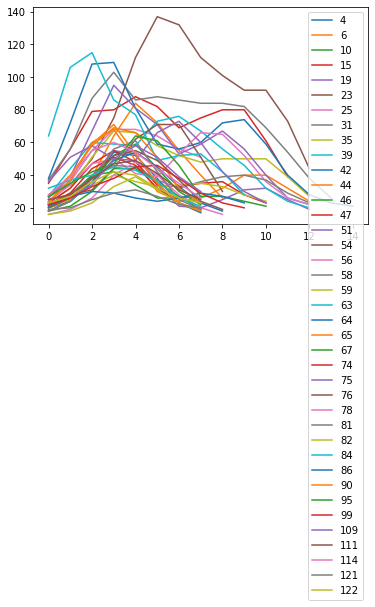

In [438]:
to_test = []
for k, b in brightnesses.items():
    if len(b) > 7:
        plt.plot(b, label=f"{k}")
        to_test.append(k)
plt.legend()

In [290]:
# # i = 50 # Should be 2
# i = 71 # Should be 1

# y = brightnesses[i]
# x = neuron_planes[i]
# plt.plot(x, y)

In [291]:
from lmfit.models import GaussianModel, ConstantModel

In [292]:
np.mean(y)

24.833333333333332

In [441]:
def aicc_correction(p, n):
    return 2*p*(p+1) / (n-p-1)

def compare_gaussian_fits(x, y):

    min_separation = 4
    # x, y = np.array(x), np.array(y)
    x, y = np.arange(len(x)), np.array(y)
    
    background = 14
    y -= background

    # background = ConstantModel()
    # pars = background.make_params()
    # pars['c'].set(value=np.min(y), min=14)
    # background = 14

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())

    pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=min_separation/2, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())

    pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
    pars['g2_sigma'].set(value=min_separation/2, min=1, max=3)
    pars['g2_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1 + gauss2# + background

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    # print(out.fit_report(min_correl=0.5))

    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(x, y)
    axes[0].plot(x, init, '--', label='initial fit')
    axes[0].plot(x, out.best_fit, '-', label='best fit')
    axes[0].legend()

    comps = out.eval_components(x=x)
    axes[1].plot(x, y)
    axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
    axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
    axes[1].legend()

    plt.show()

    results_2gauss = out
    

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())
    pars['g1_center'].set(value=len(y) / 2.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=min_separation/2, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].legend()

#     plt.show()

    results_1gauss = out
    
    
#     gauss1 = GaussianModel(prefix='g1_')
#     pars = gauss1.make_params()
#     # pars.update(gauss1.make_params())

#     pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
#     pars['g1_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g1_amplitude'].set(value=np.mean(y), min=0)

#     gauss2 = GaussianModel(prefix='g2_')
#     pars.update(gauss2.make_params())

#     pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g2_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g2_amplitude'].set(value=np.mean(y), min=0)
    
#     gauss3 = GaussianModel(prefix='g3_')
#     pars.update(gauss3.make_params())

#     pars['g3_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g3_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g3_amplitude'].set(value=np.mean(y), min=0)

#     mod = gauss1 + gauss2 + gauss3

#     init = mod.eval(pars, x=x)
#     out = mod.fit(y, pars, x=x)
    
#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
#     axes[1].plot(x, comps['g3_'], '--', label='Gaussian component 3')
#     axes[1].legend()

#     plt.show()

    results_3gauss = out
    
    return results_1gauss, results_2gauss, results_3gauss, axes


def calc_split_point_from_gaussians2(result):
    from segmentation.util.utils_postprocessing import calc_split_point_from_gaussians
    peak1 = result.values['g1_center']
    peak2 = result.values['g2_center']
    y = result.data
    
    split_point = calc_split_point_from_gaussians([int(np.floor(peak1)), int(np.ceil(peak2))], y)
    return split_point

Testing neuron 4


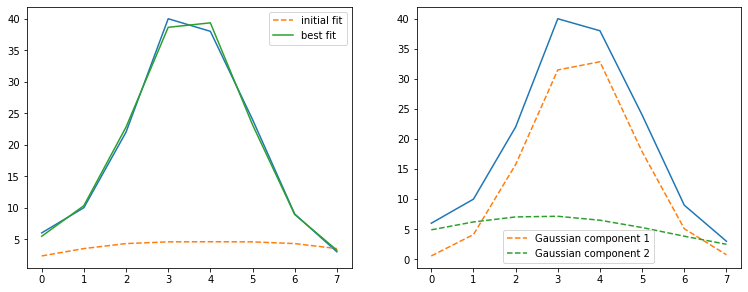

ONE GAUSSIAN
4
13.850240066098896 8.945038611271276 13.850240066098896
19.8502400660989 92.94503861127127 19.8502400660989
Testing neuron 6


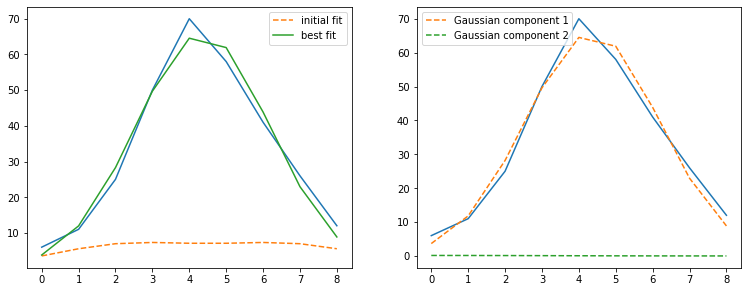

ONE GAUSSIAN
3
26.64429664453637 32.64266069174079 26.64429664453637
31.444296644536372 74.64266069174079 31.444296644536372
Testing neuron 10


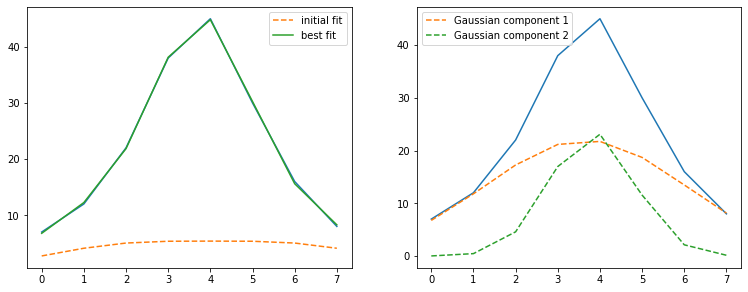

ONE GAUSSIAN
4
18.403638432768055 -10.36800203598279 18.403638432768055
24.403638432768055 73.63199796401722 24.403638432768055
Testing neuron 15


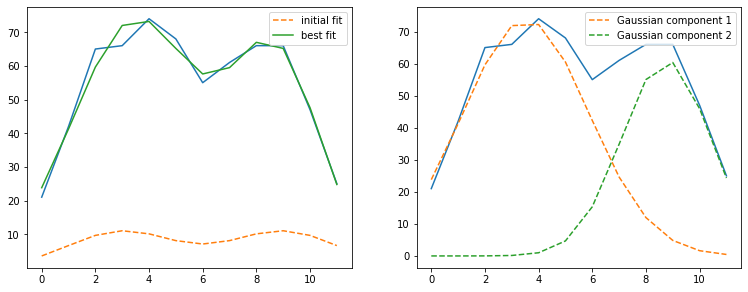

TWO GAUSSIANS
6
72.32459479024762 36.55286473232556 72.32459479024762
75.32459479024762 53.35286473232556 75.32459479024762
Testing neuron 19


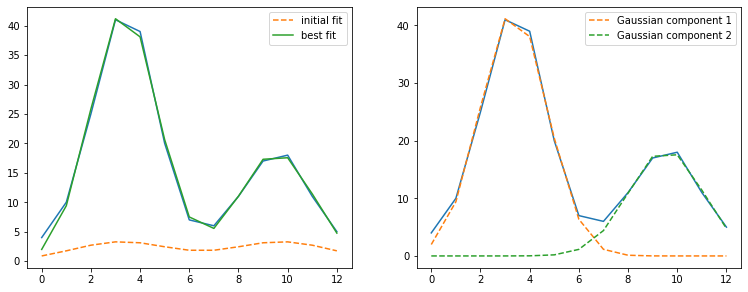

TWO GAUSSIANS
7
61.124992488343494 4.503796406211476 61.124992488343494
63.79165915501016 18.503796406211478 63.79165915501016
Testing neuron 23


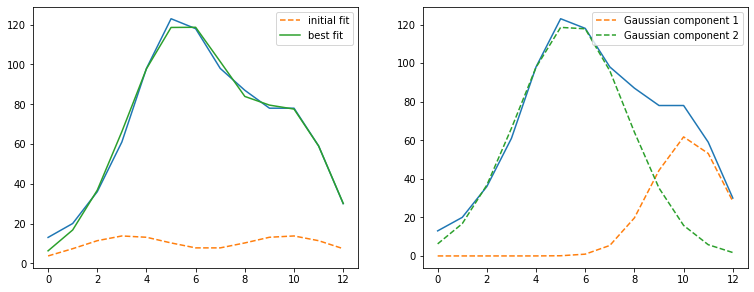

TWO GAUSSIANS
9
71.7163276748508 41.69342187141349 71.7163276748508
74.38299434151747 55.69342187141349 74.38299434151747
Testing neuron 25


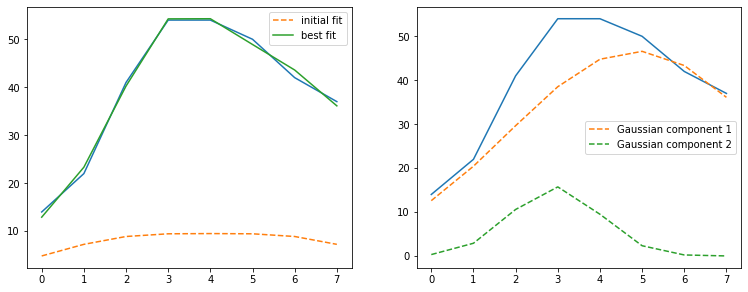

ONE GAUSSIAN
4
24.786573226348146 12.129581906712927 24.786573226348146
30.786573226348146 96.12958190671293 30.786573226348146
Testing neuron 31


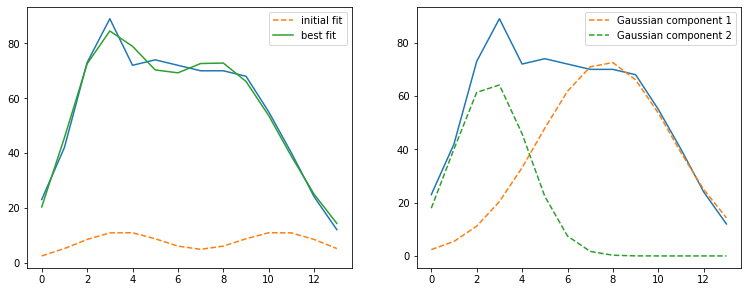

TWO GAUSSIANS
6
85.86801918095604 44.01779880499829 85.86801918095604
88.26801918095605 56.01779880499829 88.26801918095605
Testing neuron 35


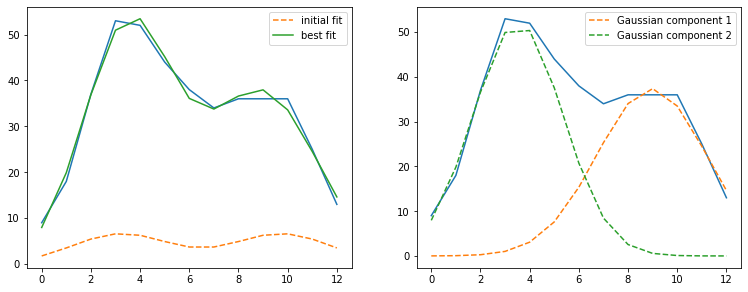

TWO GAUSSIANS
7
68.0037107913845 22.416387403660217 68.0037107913845
70.67037745805118 36.41638740366022 70.67037745805118
Testing neuron 39


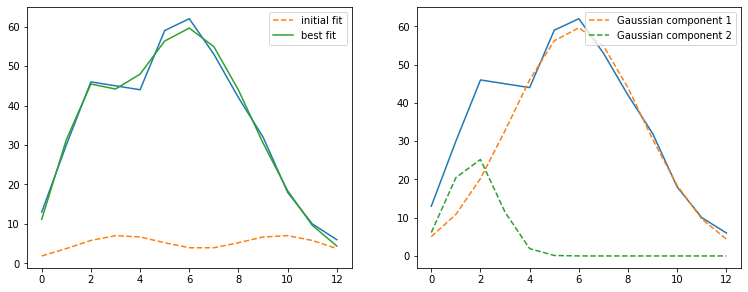

TWO GAUSSIANS
4
49.916508125417096 28.667473195774225 49.916508125417096
52.58317479208376 42.66747319577422 52.58317479208376
Testing neuron 42


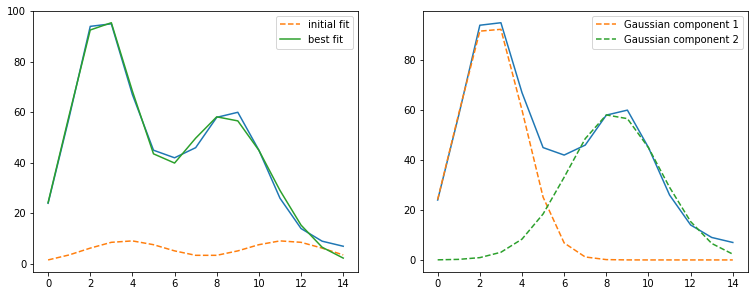

TWO GAUSSIANS
6
98.3982411746833 36.37665924098515 98.3982411746833
100.5800593565015 46.87665924098515 100.5800593565015
Testing neuron 44


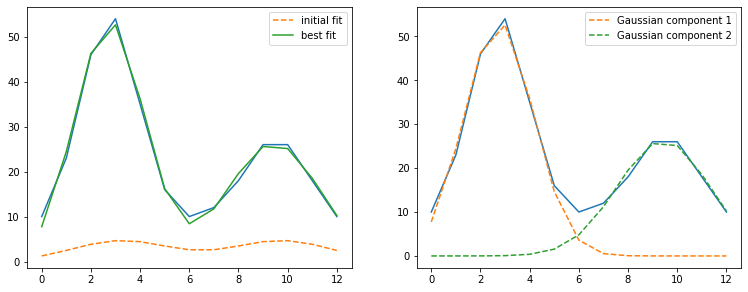

TWO GAUSSIANS
6
73.05117802919456 15.47076619972977 73.05117802919456
75.71784469586123 29.47076619972977 75.71784469586123
Testing neuron 46


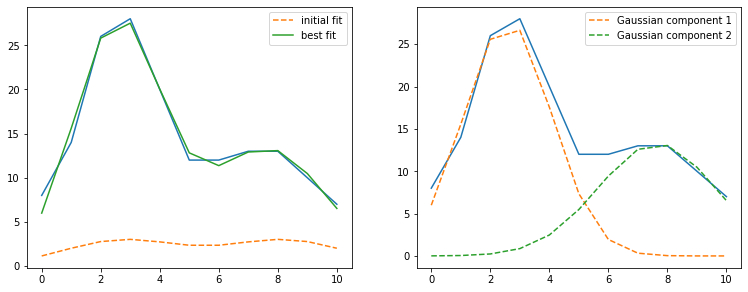

TWO GAUSSIANS
5
40.814939396707075 9.021109555899288 40.814939396707075
44.243510825278506 30.021109555899287 44.243510825278506
Testing neuron 47


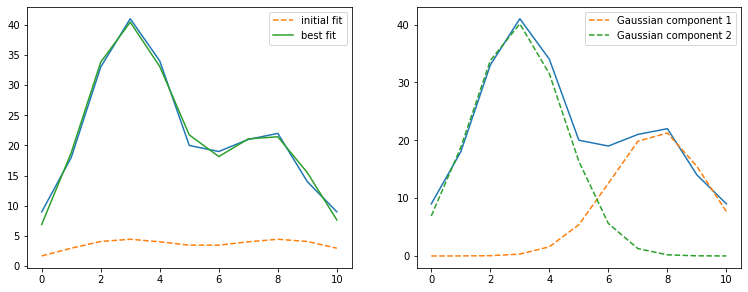

TWO GAUSSIANS
6
47.29942342833838 15.377638023377667 47.29942342833838
50.72799485690981 36.37763802337767 50.72799485690981
Testing neuron 51


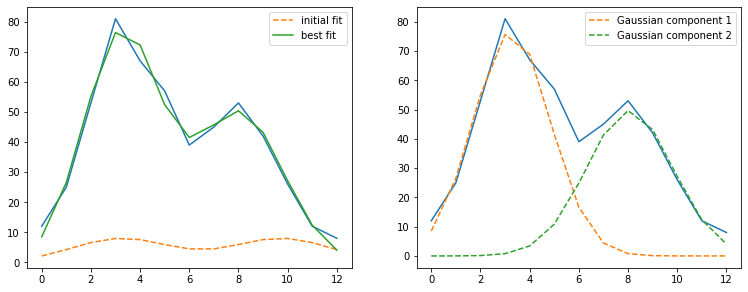

TWO GAUSSIANS
6
72.15058286712994 41.06362882117779 72.15058286712994
74.81724953379661 55.06362882117779 74.81724953379661
Testing neuron 54


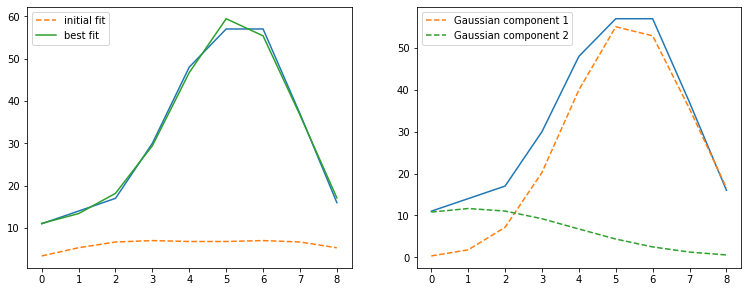

ONE GAUSSIAN
4
32.9082332502316 15.67161759315346 32.9082332502316
37.7082332502316 57.67161759315346 37.7082332502316
Testing neuron 56


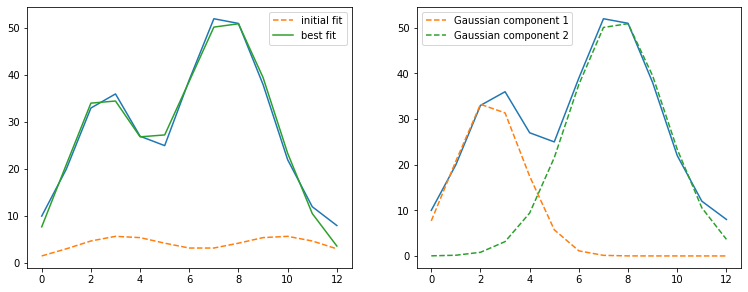

TWO GAUSSIANS
5
64.11091518071106 27.61558018920238 64.11091518071106
66.77758184737773 41.615580189202376 66.77758184737773
Testing neuron 58


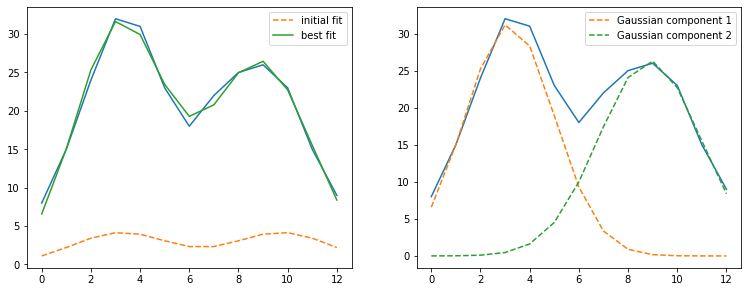

TWO GAUSSIANS
6
60.429099982465885 7.645728068556468 60.429099982465885
63.09576664913255 21.64572806855647 63.09576664913255
Testing neuron 59


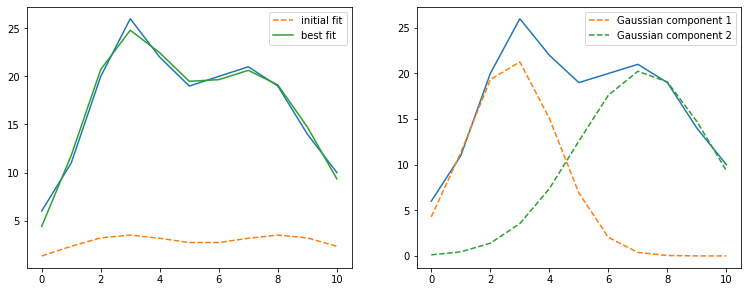

TWO GAUSSIANS
5
35.037420593934186 6.72417172743884 35.037420593934186
38.46599202250562 27.72417172743884 38.46599202250562
Testing neuron 63


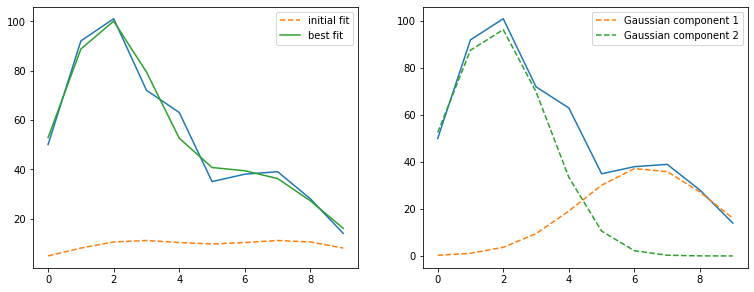

ONE GAUSSIAN
5
57.564721157640285 43.35738698784741 57.564721157640285
61.564721157640285 71.3573869878474 61.564721157640285
Testing neuron 64


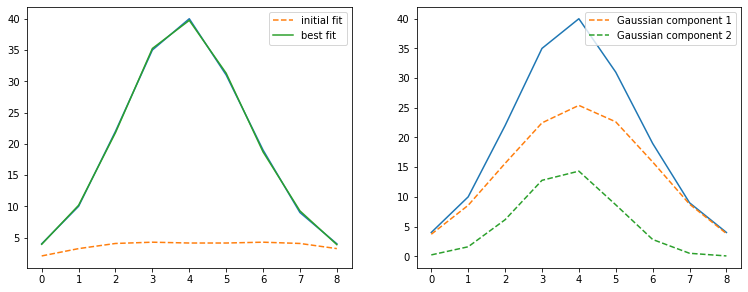

ONE GAUSSIAN
5
0.7018097117946969 -14.470369674592778 0.7018097117946969
5.501809711794697 27.529630325407222 5.501809711794697
Testing neuron 65


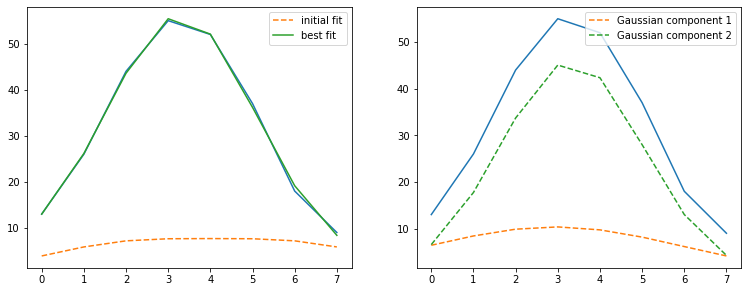

ONE GAUSSIAN
4
2.3737042088669233 3.5626365593776903 2.3737042088669233
8.373704208866924 87.5626365593777 8.373704208866924
Testing neuron 67


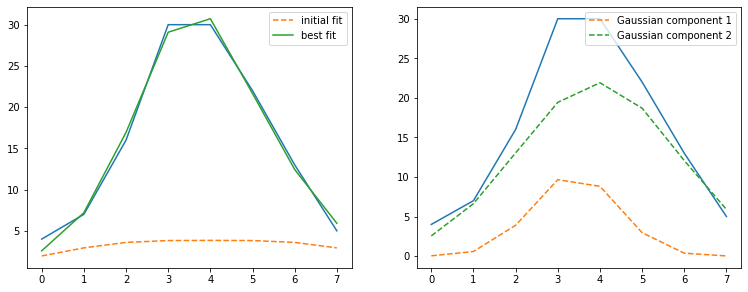

ONE GAUSSIAN
4
9.929321052185369 9.096888344661153 9.929321052185369
15.929321052185369 93.09688834466115 15.929321052185369
Testing neuron 74


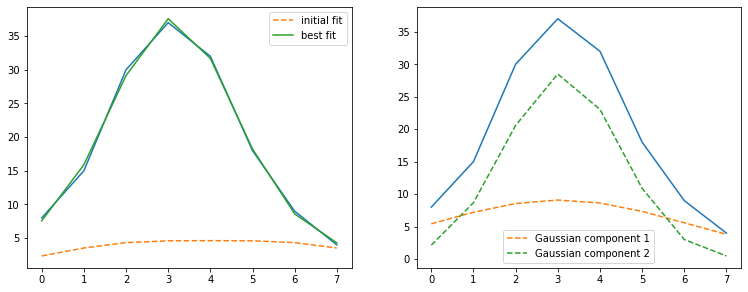

ONE GAUSSIAN
4
7.741714377843878 2.5792568972582046 7.741714377843878
13.741714377843877 86.5792568972582 13.741714377843877
Testing neuron 75


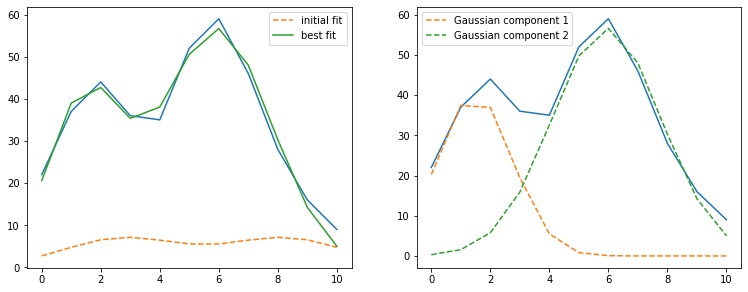

TWO GAUSSIANS
4
53.08116220304246 29.3322413158945 53.08116220304246
56.50973363161389 50.3322413158945 56.50973363161389
Testing neuron 76


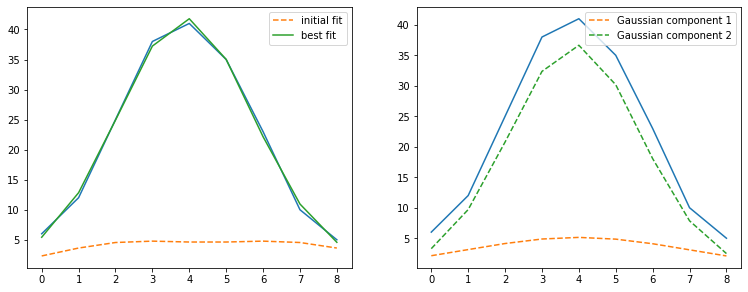

ONE GAUSSIAN
4
0.5295570024563423 4.8033565345497 0.5295570024563423
5.329557002456342 46.8033565345497 5.329557002456342
Testing neuron 78


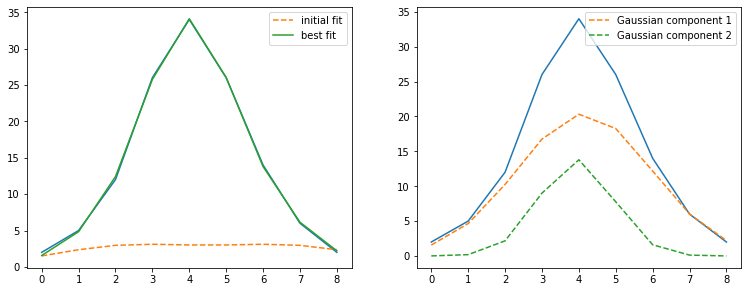

ONE GAUSSIAN
5
4.17997312230046 -12.995890883318424 4.17997312230046
8.97997312230046 29.004109116681576 8.97997312230046
Testing neuron 81


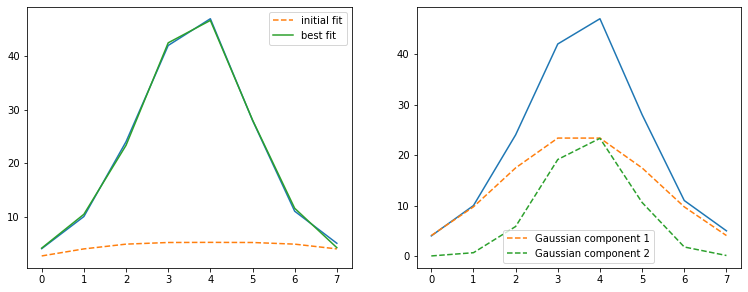

ONE GAUSSIAN
4
11.969546098497283 0.8006921223585888 11.969546098497283
17.969546098497283 84.80069212235858 17.969546098497283
Testing neuron 82


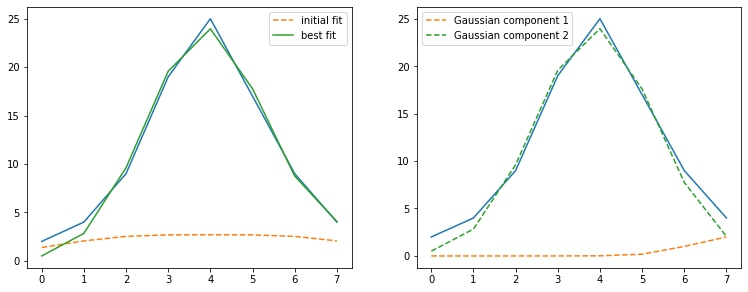

ONE GAUSSIAN
6
6.393714680504461 9.773016423982178 6.393714680504461
12.393714680504461 93.77301642398217 12.393714680504461
Testing neuron 84


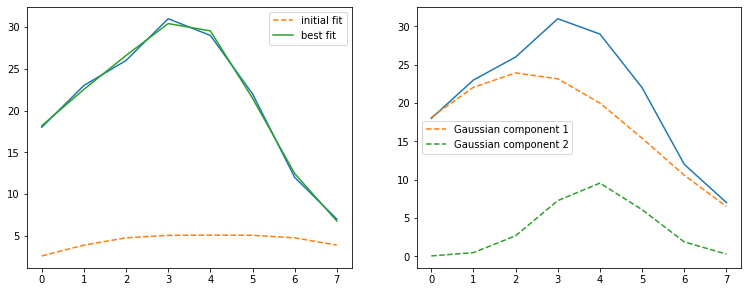

ONE GAUSSIAN
4
13.056714802168997 -0.03477571752431885 13.056714802168997
19.056714802168997 83.96522428247567 19.056714802168997
Testing neuron 86


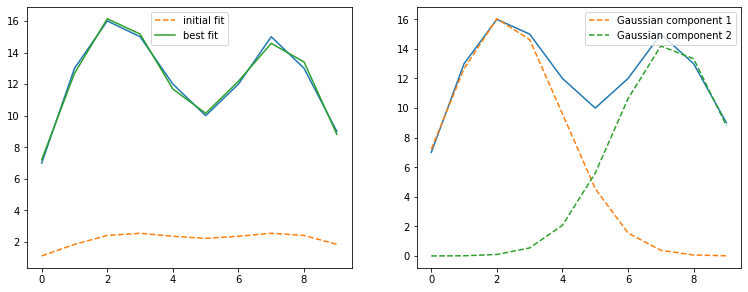

TWO GAUSSIANS
5
33.237183219928895 -14.308498790280982 33.237183219928895
37.237183219928895 13.691501209719018 37.237183219928895
Testing neuron 90


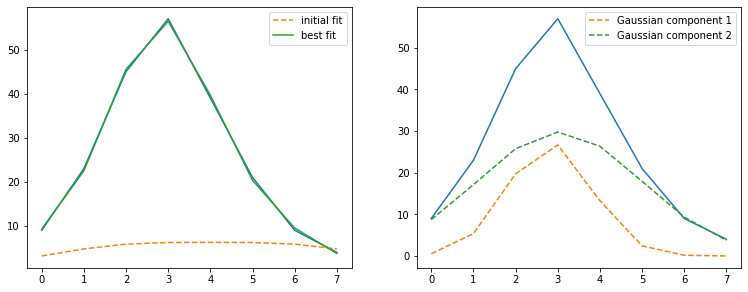

ONE GAUSSIAN
4
16.658985521202204 1.1044268514714481 16.658985521202204
22.658985521202204 85.10442685147144 22.658985521202204
Testing neuron 95


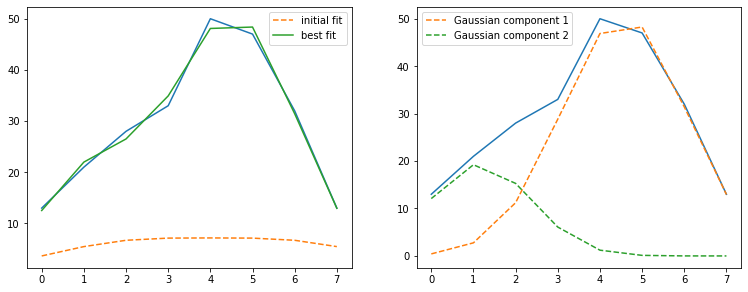

ONE GAUSSIAN
4
30.703488262622336 15.83607257765279 30.703488262622336
36.703488262622336 99.83607257765279 36.703488262622336
Testing neuron 99


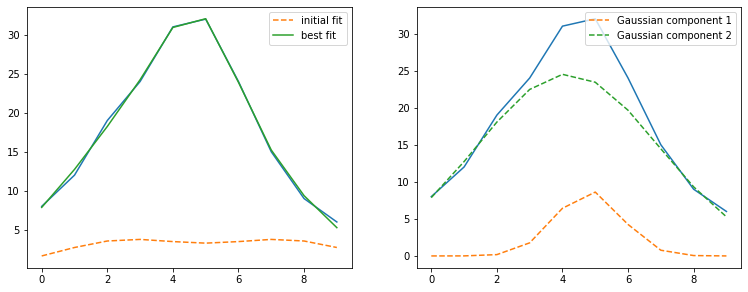

ONE GAUSSIAN
5
13.10888351697491 -4.448535457222068 13.10888351697491
17.10888351697491 23.551464542777932 17.10888351697491
Testing neuron 109


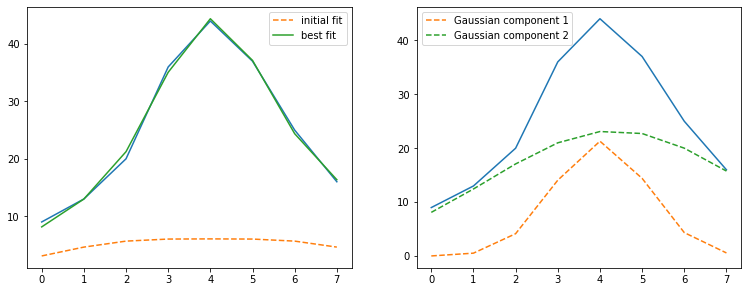

ONE GAUSSIAN
5
19.247977492319755 6.142448002734411 19.247977492319755
25.247977492319755 90.14244800273441 25.247977492319755
Testing neuron 111


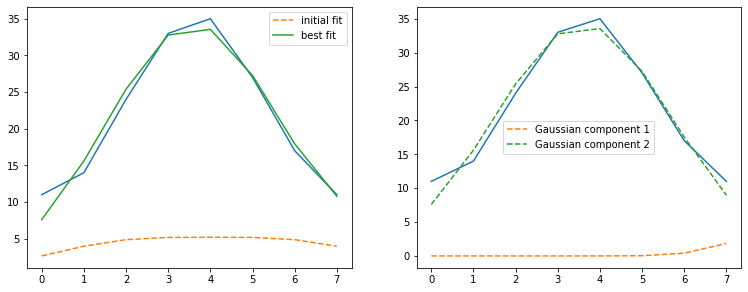

ONE GAUSSIAN
6
13.644610957033134 19.007301662345178 13.644610957033134
19.644610957033134 103.00730166234518 19.644610957033134
Testing neuron 114


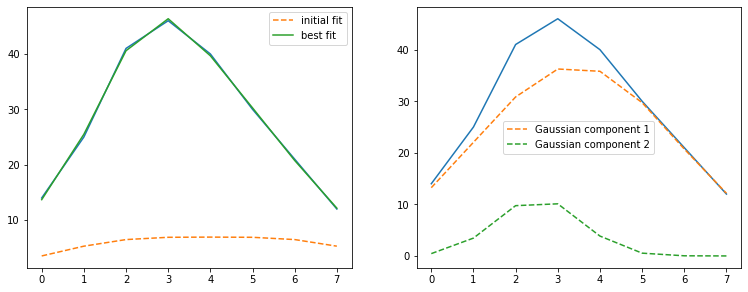

ONE GAUSSIAN
4
15.742324407034783 -5.389831776275983 15.742324407034783
21.742324407034783 78.61016822372402 21.742324407034783
Testing neuron 121


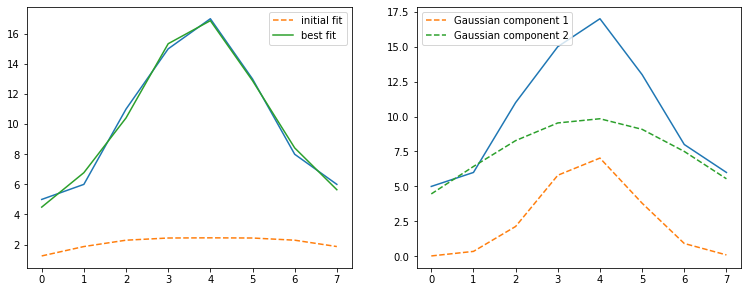

ONE GAUSSIAN
4
5.423440621621807 -0.5905495040704114 5.423440621621807
11.423440621621808 83.40945049592959 11.423440621621808
Testing neuron 122


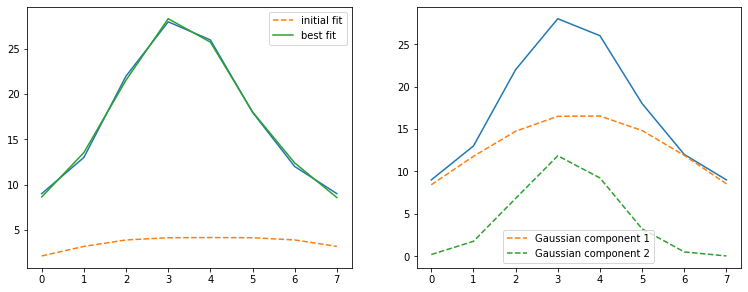

ONE GAUSSIAN
4
12.432001065255802 -3.549304317496704 12.432001065255802
18.432001065255804 80.4506956825033 18.432001065255804


In [442]:
# to_test
for i in to_test:
    print("===================================================")
    print(f"Testing neuron {i}")
    print("===================================================")
    y = brightnesses[i]
    x = neuron_planes[i]

    res1, res2, res3, axes = compare_gaussian_fits(x, y)
    
    aic1, aic2, aic3 = res1.aic, res2.aic, res3.aic
    aicc1 = aic1 + aicc_correction(res1.nvarys, len(y))
    aicc2 = aic2 + aicc_correction(res2.nvarys, len(y))
    aicc3 = aic3 + aicc_correction(res3.nvarys, len(y))
    
    print("===================================================")
    if np.argmin([aicc1, aicc2, aicc3]) == 0:
        print("ONE GAUSSIAN")
    elif np.argmin([aicc1, aicc2, aicc3]) == 1:
        print("TWO GAUSSIANS")
    else:
        print("THREE GAUSSIANS")

    # Also plot split point
    split = calc_split_point_from_gaussians2(res2)
    axes[1].plot([split, split], [0, np.max(y)])
    print(split)
    plt.show()
    
    print(aic1, aic2, aic3)
    print(aicc1, aicc2, aicc3)
    print("===================================================")
    # break

In [437]:
# res2

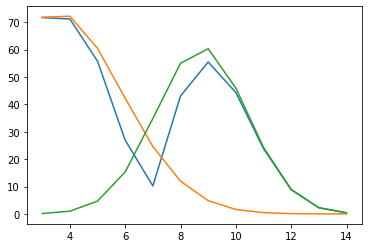

In [425]:
g1 = res2.eval_components(x=np.array(x))['g1_']
g2 = res2.eval_components(x=np.array(x))['g2_']
diff = np.array(np.abs(g1 - g2))

plt.plot(x, diff)
plt.plot(x, g1)
plt.plot(x, g2)

In [432]:

peak1 = res2.values['g1_center'] - x[0]
peak2 = res2.values['g2_center'] - x[0]
print(peak1, peak2)
peaks_of_gaussians = [int(np.floor(peak1)), int(np.ceil(peak2))]

ind = peaks_of_gaussians[0] + np.array(range(0,peaks_of_gaussians[1]+1))
inter_peak_diff = np.array(diff[ind])

0.5263479165951477 5.7526590168393295


In [445]:
from scipy.signal._peak_finding import find_peaks
find_peaks(inter_peak_diff)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [444]:
res2.data

array([ 9., 13., 22., 28., 26., 18., 12.,  9.])

In [167]:
def aicc_correction(p, n):
    return 2*p*(p+1) / (n-p-1)

p, n = 7, len(y)
aicc2 = results_2gauss.aic + aicc_correction(p,n)

p, n = 4, len(y)
aicc1 = results_1gauss.aic + aicc_correction(p,n)

aicc2, aicc

(26.358423028118168, -10.974910305215168)

In [380]:
peaks_of_gaussians[0]

3.5263479165951477

In [263]:
p2, n = 6, 11
p1 = 3
aicc_correction(p2,n), aicc_correction(p1,n)

(21.0, 3.4285714285714284)

In [183]:
from sklearn.model_selection import cross_val_score, cross_validate

In [185]:
# def residual_score(model, x, y):
#     return np.linalg.norm(model.eval(x=x) - y)

# scores = cross_validate(mod, x, y, cv=5, scoring=residual_score)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [181]:
mod.eval(x=x) - y

array([-17.20211544, -17.51605855, -20.89201807, -24.9911363 ,
       -32.99973234, -36.99999703, -37.99999999, -35.        ,
       -28.        , -22.        , -19.        ])

In [217]:
from sklearn import mixture
from sklearn.preprocessing import StandardScaler


In [235]:
x2 = x.reshape(-1,1)
scaler = StandardScaler()
y2 = scaler.fit_transform(y.reshape(-1,1))
y2 -= np.min(y2)

gmm1 = mixture.GaussianMixture(
    n_components=1, means_init=np.array([[len(y)/2.0]]).T, covariance_type='diag'
)
gmm1.fit(y2)
gmm1.bic(y2)

36.012438276105044

In [236]:
gmm2 = mixture.GaussianMixture(
    n_components=2, means_init=np.array([[len(y)/4.0, 3*len(y)/4.0]]).T, covariance_type='diag'
)
gmm2.fit(y2)
gmm2.bic(y2)

43.20612388656385

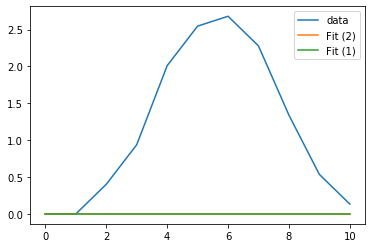

In [237]:
x2 = x.reshape(-1,1)

plt.plot(x2, y2, label="data")
plt.plot(gmm2.predict(x2), label="Fit (2)")
plt.plot(gmm1.predict(x2), label="Fit (1)")
plt.legend()